# Preprocessing Data

（修改news的输入）import包和创建路径

In [55]:
import numpy as np

Q_2 = np.array([[0.5, 1, 1], [2, 0, 0.2], [3, 2, 0]])
K_2 = np.array([[0.1, 0.5, 1], [0.5, 1, 1], [2, 2, 2]])
V_2 = np.array([[1, 0.1, 0.3], [0, 3, 0.5], [1, 1, 1]])
X = np.array([[0,1,2],[0,2,1],[2,7,5],[6,2,1],[3,4,5]])

q = X@Q_2
k = X@K_2
v = X@V_2
s = q@k.T
print(s)

[[ 57.    40.8  185.4   58.8  163.8 ]
 [ 43.5   30.6  139.5   43.2  123.9 ]
 [212.   151.6  691.6  226.   612.8 ]
 [117.    87.6  402.6  156.   355.8 ]
 [194.25 140.7  641.85 217.2  567.45]]


In [ ]:
import os
import pandas as pd
import numpy as np
import shutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, GRU, Dropout, Dense
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
price_dir = os.path.join(script_dir, 'price')
news_dir = os.path.join(script_dir, 'sampled_news') # ‘1years’ to ‘10years’
filepath_all = os.path.join(news_dir, 'all_last_1years.csv') # ‘all_last_1years.csv’ to ‘all_last_10years.csv’
filepath_nas = os.path.join(news_dir, 'nasdaq_last_1years.csv') # ‘nasdaq_last_1years.csv’ to ‘nasdaq_last_10years.csv’
data_dir = os.path.join(script_dir, 'data')

## Price

（一次性，不用运行）把sp500的所有股票名导出

In [ ]:
# url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
# tables = pd.read_html(url)
# sp500_df = tables[0]  # The first table contains the S&P 500 components

# # Save to CSV
# sp500_df.to_csv("sp500.csv", index=False)
# print("S&P 500 CSV saved successfully!")
# print(sp500_df.head())

S&P 500 CSV saved successfully!
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  


读入symbol

In [34]:
# 读取标普500数据并筛选2023年前加入的公司
symbol = pd.read_csv(os.path.join(script_dir, 'sp500_companies.csv'))
symbol['Date_added'] = pd.to_datetime(symbol['Date_added'], errors='coerce')
symbol_before_2023 = symbol[symbol['Date_added'] < pd.Timestamp('2018-12-31')]
valid_symbols = set(symbol_before_2023['Symbol'].dropna().astype(str))
print(len(valid_symbols))

403


/var/folders/5m/6pd0yxf94pdf7130mz5wyfrm0000gn/T/ipykernel_41856/1254663399.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  symbol['Date_added'] = pd.to_datetime(symbol['Date_added'], errors='coerce')


（一次性）把筛选数量和10年后的股票price表存到一个文件夹里（435支股票）->stock_price_data_preprocessed

In [35]:
output_dir = os.path.join(script_dir, 'stock_price_data_preprocessed')
os.makedirs(output_dir, exist_ok=True)


symbol435 = []

# 遍历price目录下的CSV文件
for filename in os.listdir(price_dir):
    if filename.endswith('.csv'):
        symbol_name = filename.replace('.csv', '')
        if symbol_name in valid_symbols:
            symbol435.append(symbol_name)
            file_path = os.path.join(price_dir, filename)
            df = pd.read_csv(file_path, parse_dates=['date'])
            df = df[df['date'] > pd.Timestamp('2013-12-31')]
            if not df.empty:
                df = df.rename(columns={'date': 'Date'})
                output_file_path = os.path.join(output_dir, filename)
                df.to_csv(output_file_path, index=False)

print(len(symbol435))


368


（只为了小数据集）切成只剩1年的筛选好股票的price文件夹->stock_price_data_preprocessed1

In [27]:
output_dir = os.path.join(script_dir, 'stock_price_data_preprocessed1')
os.makedirs(output_dir, exist_ok=True)

# 读取标普500数据并筛选2023年前加入的公司
symbol = pd.read_csv(os.path.join(script_dir, 'sp500_companies.csv'))
symbol['Date_added'] = pd.to_datetime(symbol['Date_added'], errors='coerce')
symbol_before_2023 = symbol[symbol['Date_added'] < pd.Timestamp('2023-12-31')]
valid_symbols = set(symbol_before_2023['Symbol'].dropna().astype(str))
symbol1 = []

# 遍历price目录下的CSV文件
for filename in os.listdir(price_dir):
    if filename.endswith('.csv'):
        symbol_name = filename.replace('.csv', '')
        if symbol_name in valid_symbols:
            symbol1.append(symbol_name)
            file_path = os.path.join(price_dir, filename)
            df = pd.read_csv(file_path, parse_dates=['date'])
            df = df[df['date'] > pd.Timestamp('2022-12-31')]
            if not df.empty:
                df = df.rename(columns={'date': 'Date'})
                output_file_path = os.path.join(output_dir, filename)
                df.to_csv(output_file_path, index=False)

print(len(symbol1))

/var/folders/5m/6pd0yxf94pdf7130mz5wyfrm0000gn/T/ipykernel_1714/2608186390.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  symbol['Date_added'] = pd.to_datetime(symbol['Date_added'], errors='coerce')


435


## News

读入news数据

In [3]:
# 读入news数据

nas = pd.read_csv(filepath_nas, parse_dates=['Date'])
nas = nas[nas['Stock_symbol'].isin(symbol_before_2023['Symbol'])]
#nas.to_csv('news_321.csv', index=False)

# chunk_size = 100
# for chunk in pd.read_csv(filepath_nas, chunksize=chunk_size):
#     nas_1 = chunk
#     break


KeyboardInterrupt: 

In [16]:
print(len(nas))
#153942

153942


（只在小数据集，不用管）把1年切成2023年

In [8]:
nas = nas[nas['Date'].dt.year == 2023].copy()
nas.to_csv('news_1y.csv', index=False)

把情绪分析前的news表拆成不同股票的csv，但已经命名为sentiment，下一步就可以直接在原表基础上加一列情绪评分列

In [ ]:
out_dir = os.path.join(script_dir, 'news_data')
os.makedirs(out_dir, exist_ok=True)
newscount = []
# 按照 Stock_symbol 分组并保存为独立的CSV文件
for stock_symbol, group_df in nas.groupby('Stock_symbol'):
    if pd.notna(stock_symbol) and str(stock_symbol).strip() != "":
        newscount.append(stock_symbol)
        filename = f"{stock_symbol}.csv"
        output_path = os.path.join(out_dir, filename)
        group_df.to_csv(output_path, index=False)

print(len(newscount))
#358

### Sentiment Analysis

暂时用nas里的summary做，因为all里article和summary很多空值。文章里最后用了Lsa summarizer

In [7]:
# 从整表中抽取10%
chunk_size = 15394 # 0.1 * len(nas)
for chunk in pd.read_csv(filepath_nas, chunksize=chunk_size):
    nas_1 = chunk
    break
print(len(nas_1))
nas_1 = nas_1.dropna(subset=['Lsa_summary', 'Stock_symbol']).reset_index(drop=True)
print(len(nas_1))
nas_1.to_csv('news_for_compare.csv', index=False)

15394
15393


#### chatgpt

用整表的形式nas_1

In [4]:
nas_1 = pd.read_csv('news_for_compare.csv')

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from tqdm import tqdm
import time



llm = ChatOpenAI(
    model="gpt-4o-mini",
    base_url='https://xiaoai.plus/v1',
    api_key='sk-MhK3dy9voyfVSwEqvV9PQwEkeOVRReh03Vhd9lO8OSCKJsNm'
)

def get_stock_sentiment(summary, stock_symbol):
    try:
        prompt = (
            f"Please analyze the sentiment of the following news towards the stock {stock_symbol}. "
            f"Return only one of the following numbers: 1 (positive), 0 (neutral), or -1 (negative). "
            f"Example1: News text: Tesla shares plummeted 12% after missing quarterly deliveries and facing regulatory scrutiny over safety concerns.; Sentiment Score: -1"
            f"Example2: News text:JPMorgan Chase maintained steady performance this quarter, with profits remaining flat compared to the previous period.; Sentiment Score: 0"
            f"News: {summary}"
        )
        response = llm.invoke([HumanMessage(content=prompt)])
        cleaned = response.content.strip()
        if cleaned not in {"1", "0", "-1"}:
            return "Error"
        return int(cleaned)
    except Exception as e:
        print(f"Error processing: {summary[:30]}... => {e}")
        return "Error"


# === 应用情绪分析，带进度条 + 限速 ===
sentiments = []
for _, row in tqdm(nas_1.iterrows(), total=len(nas_1), desc="Analyzing sentiment"):
    sentiment = get_stock_sentiment(row['Lsa_summary'], row['Stock_symbol'])
    sentiments.append(sentiment)
    time.sleep(1)  # 控制请求频率，避免触发限流

nas_1['Sentiment'] = sentiments

# === 保存结果 ===
output_dir = os.path.join(script_dir, 'gpt_for_compare')
nas_1.to_csv(output_dir, index=False)
print("✅ Sentiment analysis complete.")

Analyzing sentiment: 100%|██████████| 15393/15393 [8:35:36<00:00,  2.01s/it]   


✅ Sentiment analysis complete.


In [6]:
output_dir = os.path.join(script_dir, 'gpt_for_compare.csv')
nas_1.to_csv(output_dir, index=False)

用文件夹的形式每个股票是一个csv

In [3]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from tqdm import tqdm
import time
news_dir = os.path.join(script_dir, 'news_data')
output_dir = os.path.join(script_dir, 'sentiment_scored_gpt')

os.makedirs(output_dir, exist_ok=True)

# 收集所有 CSV 文件
csv_files = [f for f in os.listdir(news_dir) if f.endswith('.csv')]

# 初始化 GPT 接口
llm = ChatOpenAI(
    model="gpt-4o-mini",
    base_url='https://xiaoai.plus/v1',
    api_key='sk-MhK3dy9voyfVSwEqvV9PQwEkeOVRReh03Vhd9lO8OSCKJsNm'
)

# 情绪分析函数
def get_stock_sentiment(summary, stock_symbol):
    try:
        prompt = (
            f"Please analyze the sentiment of the following news towards the stock {stock_symbol}. "
            f"Return only one of the following numbers: 1 (positive), 0 (neutral), or -1 (negative). "
            f"News: {summary}"
        )
        response = llm.invoke([HumanMessage(content=prompt)])
        cleaned = response.content.strip()
        if cleaned not in {"1", "0", "-1"}:
            return "Error"
        return int(cleaned)
    except Exception as e:
        print(f"Error processing: {summary[:30]}... => {e}")
        return "Error"

# 遍历处理每个文件
for file_name in csv_files:
    file_path = os.path.join(news_dir, file_name)
    df = pd.read_csv(file_path)

    sentiments = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Analyzing {file_name}"):
        sentiment = get_stock_sentiment(row['Lsa_summary'], row['Stock_symbol'])
        sentiments.append(sentiment)
        time.sleep(1)  # 避免触发限流

    df['Sentiment'] = sentiments

    output_path = os.path.join(output_dir, f'scored_{file_name}')
    df.to_csv(output_path, index=False)
    print(f"✅ {file_name} processed and saved to {output_path}")
    break

Analyzing UAL.csv:   5%|▌         | 49/931 [01:56<34:51,  2.37s/it]


KeyboardInterrupt: 

#### finbert（还没改）

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
import os
import torch



# 加载FinBERT模型和tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# 创建情感分析pipeline
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

# 读取数据
#nas_1 = pd.read_csv('news_for_compare.csv')

def truncate_text(text, max_length=500):
    """将文本截断到最大长度"""
    return text[:max_length] if len(text) > max_length else text

def get_stock_sentiment(summary, stock_symbol):
    try:
        # 截断文本以避免长度问题
        truncated_text = truncate_text(summary)
        
        # 使用FinBERT进行情感分析
        result = nlp(truncated_text)[0]
        
        # 将FinBERT的输出映射到1, 0, -1
        label_map = {
            'Positive': 1,
            'Neutral': 0,
            'Negative': -1
        }
        
        return label_map.get(result['label'], "Error")
    except Exception as e:
        print(f"Error processing: {summary[:30]}... => {e}")
        return "Error"

# 应用情绪分析，带进度条
sentiments = []
for _, row in tqdm(nas_1.iterrows(), total=len(nas_1), desc="Analyzing sentiment"):
    sentiment = get_stock_sentiment(row['Lsa_summary'], row['Stock_symbol'])
    sentiments.append(sentiment)

nas_1['Sentiment'] = sentiments

# 保存结果
output_dir = os.path.join(script_dir, 'finbert_for_compare.csv')
nas_1.to_csv(output_dir, index=False)
print("✅ Sentiment analysis complete.")

Device set to use mps:0
Analyzing sentiment: 100%|██████████| 15393/15393 [10:45<00:00, 23.83it/s]


✅ Sentiment analysis complete.


In [11]:
print(len(nas_1['Sentiment']))

15393


#### vader

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
from tqdm import tqdm
import os


# 初始化VADER分析器
analyzer = SentimentIntensityAnalyzer()

# 读取数据
#nas_1 = pd.read_csv('news_for_compare.csv')

def get_stock_sentiment(summary, stock_symbol):
    try:
        # 获取情感分数
        scores = analyzer.polarity_scores(summary)
        
        # 根据compound分数判断情感
        if scores['compound'] >= 0.05:
            return 1  # Positive
        elif scores['compound'] <= -0.05:
            return -1  # Negative
        else:
            return 0  # Neutral
    except Exception as e:
        print(f"Error processing: {summary[:30]}... => {e}")
        return "Error"

# 应用情绪分析，带进度条
sentiments = []
for _, row in tqdm(nas_1.iterrows(), total=len(nas_1), desc="Analyzing sentiment"):
    sentiment = get_stock_sentiment(row['Lsa_summary'], row['Stock_symbol'])
    sentiments.append(sentiment)

nas_1['Sentiment'] = sentiments

# 保存结果
output_dir = os.path.join(script_dir, 'vader_for_compare.csv')
nas_1.to_csv(output_dir, index=False)
print("✅ VADER sentiment analysis complete.")

Analyzing sentiment: 100%|██████████| 15393/15393 [00:05<00:00, 2813.84it/s]


✅ VADER sentiment analysis complete.


#### textblob（还没改）

In [13]:
from textblob import TextBlob
import pandas as pd
from tqdm import tqdm
import os



def get_stock_sentiment(summary, stock_symbol):
    try:
        # 使用TextBlob进行情感分析
        analysis = TextBlob(summary)
        
        # 获取情感极性（polarity），范围在[-1, 1]之间
        polarity = analysis.sentiment.polarity
        
        # 根据polarity判断情感类别
        if polarity > 0:
            return 1  # Positive
        elif polarity < 0:
            return -1  # Negative
        else:
            return 0  # Neutral
    except Exception as e:
        print(f"Error processing: {summary[:30]}... => {e}")
        return "Error"

# 应用情绪分析，带进度条
sentiments = []
for _, row in tqdm(nas_1.iterrows(), total=len(nas_1), desc="Analyzing sentiment"):
    sentiment = get_stock_sentiment(row['Lsa_summary'], row['Stock_symbol'])
    sentiments.append(sentiment)

nas_1['Sentiment'] = sentiments

# 保存结果
output_dir = os.path.join(script_dir, 'textblob_for_compare.csv')
nas_1.to_csv(output_dir, index=False)
print("✅ TextBlob sentiment analysis complete.")

Analyzing sentiment: 100%|██████████| 15393/15393 [00:07<00:00, 1969.02it/s]


✅ TextBlob sentiment analysis complete.


compare other approaches to gpt

In [1]:
import os
import pandas as pd
import numpy as np

gpt = pd.read_csv('gpt_for_compare.csv')
vader = pd.read_csv('vader_for_compare.csv')
textblob = pd.read_csv('textblob_for_compare.csv')
finbert = pd.read_csv('finbert_for_compare.csv')

vader = vader.rename(columns={'Sentiment': 'vader_sentiment'})
textblob = textblob.rename(columns={'Sentiment': 'textblob_sentiment'})
finbert = finbert.rename(columns={'Sentiment': 'finbert_sentiment'})
gpt = gpt.rename(columns={'Sentiment': 'gpt_sentiment'})

# # 3. 只保留需要的列（假设所有表都有Stock_symbol和Lsa_summary作为关键列）
compare = gpt
compare['vader_sentiment'] = vader['vader_sentiment']
compare['textblob_sentiment'] = textblob['textblob_sentiment']
compare['finbert_sentiment'] = finbert['finbert_sentiment']

print(compare.head())


   Unnamed: 0                       Date  \
0         0.0  2023-12-16 23:00:00+00:00   
1         1.0  2023-12-12 00:00:00+00:00   
2         2.0  2023-12-12 00:00:00+00:00   
3         3.0  2023-12-07 00:00:00+00:00   
4         4.0  2023-12-07 00:00:00+00:00   

                                       Article_title Stock_symbol  \
0  Interesting A Put And Call Options For August ...            A   
1  Wolfe Research Initiates Coverage of Agilent T...            A   
2  Agilent Technologies Reaches Analyst Target Price            A   
3  Agilent (A) Enhances BioTek Cytation C10 With ...            A   
4  Pre-Market Most Active for Dec 7, 2023 : SQQQ,...            A   

                                                 Url  Publisher  Author  \
0  https://www.nasdaq.com/articles/interesting-a-...        NaN     NaN   
1  https://www.nasdaq.com/articles/wolfe-research...        NaN     NaN   
2  https://www.nasdaq.com/articles/agilent-techno...        NaN     NaN   
3  https://www.nasda


Error Counts (2):
gpt_sentiment         45
vader_sentiment        0
textblob_sentiment     0
finbert_sentiment      0
Name: 2, dtype: int64


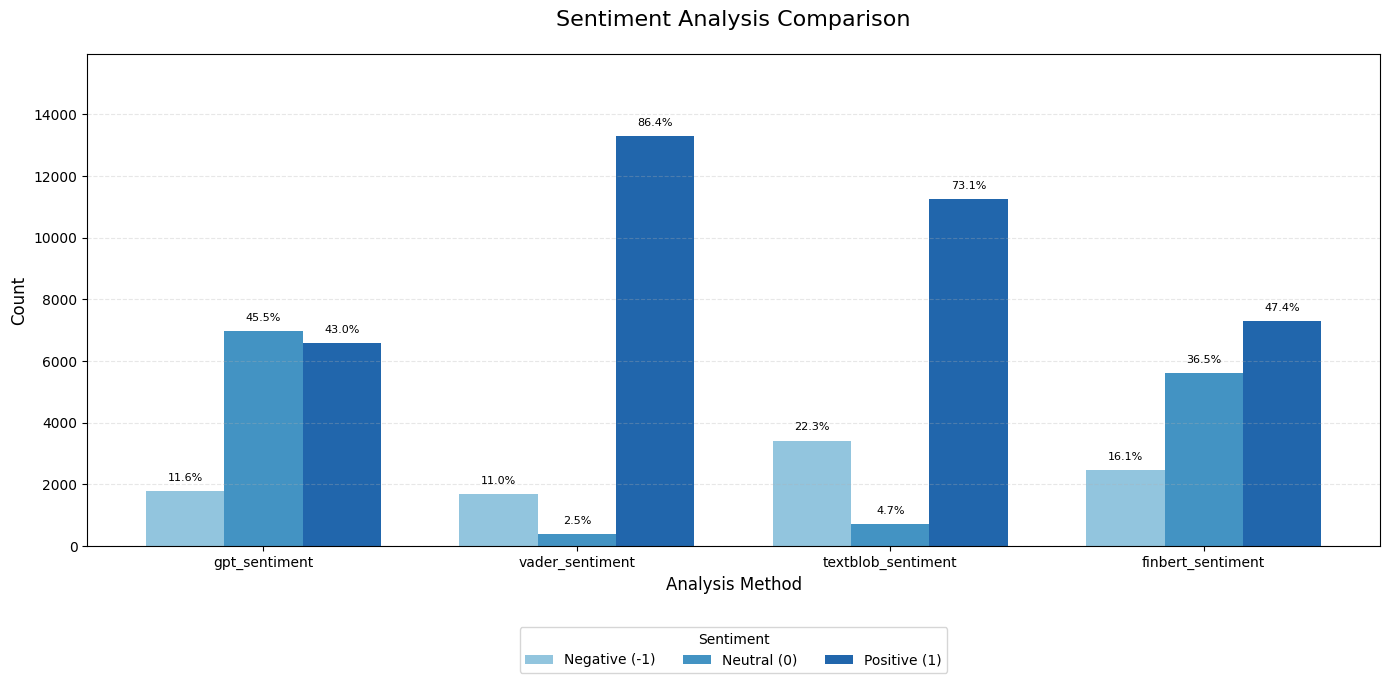

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 假设这是你的数据
columns_to_compare = ['gpt_sentiment', 'vader_sentiment', 'textblob_sentiment', 'finbert_sentiment']

# 1. 数据处理
for col in columns_to_compare:
    compare[col] = compare[col].replace('Error', 2)  # 替换Error为2
    compare[col] = pd.to_numeric(compare[col], errors='coerce').fillna(2).astype(int)

# 2. 计算绝对数量和百分比
counts = {}
percentages = {}

for col in columns_to_compare:
    # 计算绝对数量（包含2/Error，但我们只关心-1,0,1）
    count_series = compare[col].value_counts().reindex([-1, 0, 1, 2], fill_value=0)
    counts[col] = count_series
    
    # 计算百分比（排除Error/2）
    total = count_series[-1] + count_series[0] + count_series[1]  # 只计算-1,0,1的总和
    percentages[col] = count_series / total * 100 if total > 0 else pd.Series([0,0,0], index=[-1,0,1])

# 3. 准备绘图数据（转置数据框，使分析方法为行，情绪值为列）
counts_df = pd.DataFrame(counts).loc[[-1, 0, 1]].T  # 转置数据框
percent_df = pd.DataFrame(percentages).loc[[-1, 0, 1]].T  # 转置数据框

# 4. 绘制条形图（分组条形图）
plt.figure(figsize=(14, 7))
plt.subplots_adjust(left=0.05, right=0.95)

# 设置每个组的宽度和位置
bar_width = 0.25
index = np.arange(len(columns_to_compare))

# 为每种情绪值绘制条形
colors = ['#92c5de', '#4393c3', '#2166ac']  # 红(-1),黄(0),绿(1)
sentiments = [-1, 0, 1]
labels = ['Negative (-1)', 'Neutral (0)', 'Positive (1)']

for i, sentiment in enumerate(sentiments):
    ax = plt.bar(index + i*bar_width, counts_df[sentiment], bar_width,
                label=labels[i], color=colors[i], edgecolor='none')

# 5. 添加数值标签（百分比）
for i, model in enumerate(counts_df.index):
    for j, sentiment in enumerate(sentiments):
        height = counts_df.loc[model, sentiment]
        pct = percent_df.loc[model, sentiment]
        if height > 0:  # 只显示有值的标签
            plt.text(i + j*bar_width, height + 0.02*counts_df.max().max(),
                    f"{pct:.1f}%",
                    ha='center', va='bottom', fontsize=8)

# 6. 图表美化
plt.title('Sentiment Analysis Comparison', fontsize=16, pad=20)
plt.xlabel('Analysis Method', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(index + bar_width, columns_to_compare)
plt.legend(title='Sentiment', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(0, counts_df.max().max() * 1.2)  # 为标签留出空间

# 7. 打印Error统计
error_counts = pd.DataFrame(counts).loc[2]
print("\nError Counts (2):")
print(error_counts)

plt.tight_layout()
plt.show()

In [6]:
results = {}
methods = ['vader', 'textblob', 'finbert']

for col in ['gpt_sentiment', 'vader_sentiment', 'textblob_sentiment', 'finbert_sentiment']:
    if col in compare.columns:
        # 将列转换为数值类型，无法转换的设为NaN
        compare[col] = pd.to_numeric(compare[col], errors='coerce')
        
        # 将"Error"等字符串标记转换为NaN（如果存在）
        compare[col] = compare[col].replace('Error', np.nan)
                                            
for method in methods:
    col = f'{method}_sentiment'
    
    # 过滤掉无效值（如果有）
    valid_data = compare.dropna(subset=['gpt_sentiment', col])
    
    # 计算绝对差平均值
    abs_diff = np.mean(np.abs(valid_data['gpt_sentiment'] - valid_data[col]))
    
    # 计算均方误差（MSE）
    mse = np.mean((valid_data['gpt_sentiment'] - valid_data[col])**2)
    
    results[method] = {
        'absolute_difference_mean': abs_diff,
        'mean_squared_error': mse
    }

results_df = pd.DataFrame(results).T
print("\n各方法与GPT情绪的差异分析:")
print(results_df)


各方法与GPT情绪的差异分析:
          absolute_difference_mean  mean_squared_error
vader                     0.633177            0.811441
textblob                  0.820302            1.155981
finbert                   0.447941            0.524433
